In [1]:
import pathlib
import sys
module_dir = pathlib.Path("").parent.resolve()
root_dir = module_dir.parent
source_dir = root_dir.joinpath("source")
model_dir = root_dir.joinpath("model")
asvlite_wrapper_dir = root_dir.joinpath("dependency", "ASVLite", "wrapper", "cython")
sys.path.insert(0, str(source_dir))
sys.path.insert(0, str(asvlite_wrapper_dir))

In [2]:
import pyproj
import ctypes
import cartopy.crs as ccrs
from datetime import datetime, timedelta
from pathlib import Path
import os
import epsg
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm 
import cds
from netcdf import NetCDF_wave, NetCDF_current
from rudder_controller import Rudder_PID_controller
from sea_surface import py_Sea_surface
from asv import py_Asv_specification, py_Asv
from geometry import py_Coordinates_3D
from geometry import py_normalise_angle_PI, py_normalise_angle_2PI
from sklearn.linear_model import LinearRegression, Perceptron
from joblib import load

In [3]:
# Simulation output directory
output_dir = root_dir.joinpath(*"results/glider_thrust/benjamin_in_freda".split("/"))  
output_dir.mkdir(parents=True, exist_ok=True)

In [4]:
# Time
time_step_size = 40.0 # Simulation time step size in milliseconds
start_time = datetime(2012, 12, 28, 12) # Start time of simulation
end_time   = datetime(2013, 1, 4)# End time of simulation

year_1 = str(start_time.year)
year_2 = str(end_time.year)
month_1 = str(start_time.month).zfill(2)
month_2 = str(end_time.month).zfill(2)

In [5]:
# Downloads the wave data for the period 
nc_data_wave = {}
nc_files = ["{}_{}.nc".format(year_1, month_1), "{}_{}.nc".format(year_2, month_2)]
for file in nc_files:
    cds_dir = root_dir.joinpath("data", "cds", "pacx", "waves")
    nc_file = cds_dir.joinpath(file)
    if not os.path.exists(str(nc_file)):
        # Make the cds dir if it does not exist.
        cds_dir.mkdir(parents=True, exist_ok=True)
        # nc file does not exist, download it.
        year, month = file[:-3].split("_")
        north = 40
        south = -40
        east = 180
        west = -180
        cds.get_wave_data(int(year), int(month), north, south, east, west, str(nc_file))
    else:
        print("Found {}".format(file))
    # Load the nc file
    nc_data_wave[file] = NetCDF_wave(nc_file)

Found 2012_12.nc
Found 2013_01.nc


In [6]:
# Downloads the ocean current data for the period 
nc_data_current = {}
tar_files = ["{}_{}.tar.gz".format(year_1, month_1), "{}_{}.tar.gz".format(year_2, month_2)]
for file in tar_files:
    cds_dir = root_dir.joinpath("data", "cds", "pacx", "ocean_currents")
    tar_file = cds_dir.joinpath(file)
    if not os.path.exists(str(tar_file)):
        # Make the cds dir if it does not exist.
        cds_dir.mkdir(parents=True, exist_ok=True)
        # tar file does not exist, download it.
        year, month = file[:-7].split("_")
        cds.get_ocean_current_data(int(year), int(month), str(tar_file))
    else:
        print("Found {}".format(file))
    # Load the nc file
    for year, month in [(year_1, month_1), (year_2, month_2)]:
        for day in range(1, 32):
            file_name = "{}_{}_{}.nc".format(year, str(month).zfill(2), str(day).zfill(2)) 
            nc_file = cds_dir.joinpath(file_name)
            if os.path.exists(nc_file):
                nc_data_current[file_name] = NetCDF_current(str(nc_file))

Found 2012_12.tar.gz
Found 2013_01.tar.gz


In [7]:
# Helper function to get wave data for a given location and time.
def get_wave_data_at(longitude, latitude, time):
    year = time.year
    month = time.month
    file_name = "{}_{}.nc".format(year, str(month).zfill(2))
    wave_hs, wave_dp = nc_data_wave[file_name].get_wave_data_at(longitude, latitude, time)
    return (wave_hs, wave_dp)

In [8]:
def get_ocean_current_at(longitude, latitude, time):
    year = time.year
    month = time.month
    day = time.day
    file_name = "{}_{}_{}.nc".format(year, str(month).zfill(2), str(day).zfill(2))
    v_zonal, v_meridional = nc_data_current[file_name].get_ocean_current_at(longitude, latitude, time)
    if v_zonal == None or v_meridional == None:
        print("Ocean current data not available for ({}, {}) at time {} in file {}".format(longitude, latitude, time, file_name))
        v_zonal, v_meridional = (0, 0)
    return (v_zonal, v_meridional)

In [9]:
# Load Benjamin's log file
log_file = root_dir.joinpath(*"data/pacx/logs/1.1/data/0-data/PacX_NODC_master_folder/benjamin/moseg_benjamin.txt".split("/"))
df = pd.read_csv(str(log_file))
df["Timestamp(UTC)"] = pd.to_datetime(df["Timestamp(UTC)"]) # Convert column Timestamp to datetime format

In [10]:
# Trim the dataframe to remove log of period that we are not interested in.
# Keep only the data between start_time and end_time of the storm.
df = df[(df["Timestamp(UTC)"] >= start_time) & (df["Timestamp(UTC)"] <= end_time)]
df.reset_index(drop=True, inplace=True)
i_start = df.first_valid_index() # Index of first row
df

,Timestamp(UTC),Latitude,Longitude,Wave Height(meters),Wave Direction(degrees T),Average Wave Period(seconds),Dominant Wave Period(seconds)
0,2012-12-28 12:00:01,-17.7580,162.7603,2.0,25,6.1,8.0
1,2012-12-28 13:00:01,-17.7600,162.7496,1.8,42,5.9,8.0
2,2012-12-28 14:00:01,-17.7620,162.7385,2.0,31,6.1,7.5
3,2012-12-28 15:00:01,-17.7645,162.7256,2.0,64,5.7,6.4
4,2012-12-28 16:00:01,-17.7665,162.7155,1.9,54,5.5,7.1
...,...,...,...,...,...,...,...
151,2013-01-03 19:00:01,-17.2609,161.0923,1.7,156,5.6,9.1
152,2013-01-03 20:00:01,-17.2567,161.0687,1.7,151,5.6,9.1
153,2013-01-03 21:00:01,-17.2545,161.0444,1.8,155,5.8,9.1
154,2013-01-03 22:00:01,-17.2555,161.0218,1.9,141,5.6,9.8


In [11]:
# Load the model for thrust tuning
file_name = model_dir.joinpath("thrust_tuning_lin_reg_4.joblib")
thrust_tuning_factor_model = load(str(file_name)) 

In [12]:
_MPS_TO_KNOTS = 1.94384449 # 1 m/s = 1.94384449 knots
def get_thrust_tuning_factor(wave_ht, zonal_current_velocity, meridional_current_velocity, vehicle_heading):
    current_speed = math.sqrt(zonal_current_velocity*zonal_current_velocity + meridional_current_velocity*meridional_current_velocity) * _MPS_TO_KNOTS
    theta = math.atan2(zonal_current_velocity, meridional_current_velocity)
    theta = py_normalise_angle_2PI(theta)
    relative_current_direction = abs(py_normalise_angle_PI(theta - vehicle_heading)) # (0, PI) radians
    return thrust_tuning_factor_model.predict([[wave_ht, current_speed, relative_current_direction]])

In [13]:
# Wave glider specs
asv_spec = py_Asv_specification()
asv_spec.L_wl       = 2.1 # m
asv_spec.B_wl       = 0.6 # m
asv_spec.D          = 0.25 # m 
asv_spec.T          = 0.09 # m
asv_spec.max_speed  = 4.0 # m/s
asv_spec.disp       = 0.09 # m3
asv_spec.r_roll     = 0.2 # m
asv_spec.r_pitch    = 0.6 # m
asv_spec.r_yaw      = 0.6 # m
asv_spec.cog        = py_Coordinates_3D(1.05, 0.0, -3.0) # m

In [14]:
# Start position
start_position_GCS = py_Coordinates_3D(df.loc[i_start, " Longitude"], df.loc[i_start, " Latitude"])
x, y = epsg.GCS_to_PCS(start_position_GCS.x, start_position_GCS.y)
start_position_PCS = py_Coordinates_3D(x, y)

In [15]:
# Start attitude
lat1  = df.loc[i_start, " Latitude"]
long1 = df.loc[i_start, " Longitude"]
lat2  = df.loc[i_start+1, " Latitude"]
long2 = df.loc[i_start+1, " Longitude"]
geodesic = pyproj.Geod(ellps='WGS84')
fwd_azimuth, back_azimuth, distance = geodesic.inv(long1, lat1, long2, lat2)
fwd_azimuth = fwd_azimuth if fwd_azimuth >= 0.0 else (360 + fwd_azimuth)
start_attitude = py_Coordinates_3D(0.0, 0.0, math.pi/180.0 * fwd_azimuth) 

In [16]:
# Sea surface
wave_rand_seed = 1
count_wave_spectral_directions = 5
count_wave_spectral_frequencies = 7
wave_hs, wave_dp = get_wave_data_at(start_position_GCS.x, start_position_GCS.y, start_time) 
sea_surface = py_Sea_surface(wave_hs, wave_dp, wave_rand_seed, count_wave_spectral_directions, count_wave_spectral_frequencies)

In [17]:
# Initialise the wave glider
asv = py_Asv(asv_spec, sea_surface, start_position_PCS, start_attitude)

In [18]:
# Initialise the rudder controller
rudder_controller = Rudder_PID_controller(asv_spec, [1.25, 0.25, 1.75])
rudder_angle = 0.0

In [19]:
# Waypoints
waypoints = []
for i in range(1, len(df)):
    waypoint_GCS = py_Coordinates_3D(df.loc[i, " Longitude"], df.loc[i, " Latitude"])
    x, y = epsg.GCS_to_PCS(waypoint_GCS.x, waypoint_GCS.y)
    waypoint_PCS = py_Coordinates_3D(x, y)
    waypoints.append(waypoint_PCS)

In [20]:
# Simulate till last waypoint
proximity_margin = 10.0 # m
i_waypoint = 0
start_time = df.loc[0, "Timestamp(UTC)"] 
time = start_time - timedelta(milliseconds=40)
simulated_path = []
currents = []
simulation_timestamps = []
df["Timestamp(simulated)"] = df["Timestamp(UTC)"] 

# Show a progress bar
pbar = tqdm(total = len(waypoints)-1)
pbar.set_description("Benjamin simulation progress")

# Simulate till last waypoint
has_not_reached_final_waypoint = True
while True:
    # Increment time
    time = time + timedelta(seconds=time_step_size/1000.0)
    # Check if reached the waypoint  
    position = asv.py_get_position_cog() # Get the current position in PCS.
    simulated_path.append(position)
    simulation_timestamps.append(time)
    dx = position.x - waypoints[i_waypoint].x 
    dy = position.y - waypoints[i_waypoint].y 
    distance = math.sqrt(dx*dx + dy*dy) # m
    if distance <= proximity_margin:
        # Reached current waypoint
        pbar.update(1)
        df.loc[i_waypoint+1, "Timestamp(simulated)"] = time
        # Increment to next waypoint 
        if i_waypoint == len(waypoints)-1: 
            # Reached the final waypoint
            break
        else:
            i_waypoint += 1
    # Get the sea state
    wg_longitude, wg_latitude = epsg.PCS_to_GCS(position.x, position.y)
    new_hs, new_dp = get_wave_data_at(wg_longitude, wg_latitude, time)
    v_zonal, v_meridional = get_ocean_current_at(wg_longitude, wg_latitude, time) 
    currents.append((v_zonal, v_meridional))
    if new_hs == None or new_dp == None:
        print("{}: Wave data not available.".format(time))
        break
    # Compare the sea state with the current sea state
    current_hs = sea_surface.py_get_significant_height() # m
    current_dp = sea_surface.py_get_predominant_heading() # radians
    is_sea_state_same = (float(new_hs) == float(current_hs) and float(new_dp == current_dp))
    # If the sea state has changed then, set the new sea state in the wave glider
    if not is_sea_state_same:
        new_sea_surface = py_Sea_surface(new_hs, new_dp, wave_rand_seed, count_wave_spectral_directions, count_wave_spectral_frequencies)
        asv.py_set_sea_state(new_sea_surface)                 
    # Set rudder angle
    rudder_angle = rudder_controller.get_rudder_angle(asv, waypoints[i_waypoint])
    # Set thrust tuning factor
    asv_attitude = asv.py_get_attitude()
    thrust_tuning_factor = get_thrust_tuning_factor(new_hs, v_zonal, v_meridional, asv_attitude.z)
    asv.py_wg_set_thrust_tuning_factor(thrust_tuning_factor)
    # Compute dynamics
    try:
        asv.py_set_ocean_current(v_zonal, v_meridional)
        asv.py_wg_compute_dynamics(rudder_angle, time_step_size)
    except Exception as e:
        print(str(e))

pbar.close()

# Error in time for each waypoint
df["time_error(hrs)"] =  (df["Timestamp(UTC)"] - df["Timestamp(simulated)"]).apply(lambda row: row.total_seconds()/3600.0)
# Error in position for each time in the log
df["position_error(km)"] = 0.0
for i in range(len(df)):
    time = df.loc[i, "Timestamp(UTC)"]
    i_time = int((time - start_time).total_seconds()*1000.0/time_step_size)
    if i_time < len(simulation_timestamps):
        x1, y1 = epsg.GCS_to_PCS(df.loc[i, " Longitude"], df.loc[i, " Latitude"]) # Actual position
        x2, y2 = simulated_path[i_time].x, simulated_path[i_time].y # Simulated position for the same time
        delta_x = (x2 -x1) if (x2 * x1) >= 0 else (x2 + x1) 
        delta_y = (y2 -y1) if (y2 * y1) >= 0 else (y2 + y1) 
        df.loc[i, "position_error(km)"] = math.sqrt(delta_x**2 + delta_y**2)/1000
    else:
        df.loc[i, "position_error(km)"] = np.nan

# Write simulated path to file
df.to_csv("{}/simulated_log.csv".format(output_dir))
f = open("{}/simulated_path.csv".format(output_dir), "w")
f.write("x,y,timestamp\n")
for i in range(len(simulated_path)):
    f.write("{},{},{}\n".format(simulated_path[i].x, simulated_path[i].y, simulation_timestamps[i]))
f.close()


# Write simulated ocean currents to file
f = open("{}/simulated_currents.csv".format(output_dir), "w")
for item in currents:
    f.write("{},{}\n".format(item[0], item[1]))
f.close()

Benjamin simulation progress: : 155it [42:48, 16.57s/it]                                                                                                                                                           


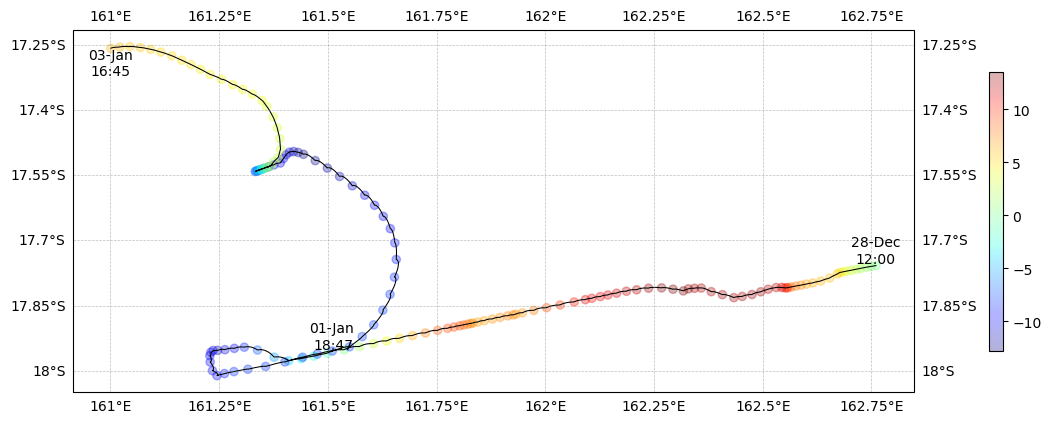

In [21]:
# Set plot size
width = 12
height = 6
plt.rcParams['figure.figsize'] = [width, height]
plt.style.use('seaborn-v0_8-muted') # Setting a style sheet for matplotlib
%matplotlib inline  

# Plot the simulated and actual path of the wave glider along with time error at waypoints.
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
# Set the extent of the plot
# latitude_max, latitude_min, longitude_max, longitude_min = (-17, -18.2, 160, 163.5)
# ax.set_xlim(longitude_min, longitude_max)
# ax.set_ylim(latitude_min, latitude_max)
# Plot map
ax.coastlines(color='grey', linewidth=0.5)
# Plot waypoints
longitudes = df[" Longitude"]
latitudes  = df[" Latitude"]
sc = plt.scatter(x=longitudes, y=latitudes, alpha=0.3, c=df["time_error(hrs)"], cmap=plt.get_cmap("jet"))
plt.colorbar(sc, fraction=0.015, pad=0.08)
# Plot simulated path
longitudes = []
latitudes = []
for point in simulated_path[::25]:
    longitude, latitude = epsg.PCS_to_GCS(point.x, point.y)
    longitudes.append(longitude)
    latitudes.append(latitude)
plt.plot(longitudes, latitudes, color='black', linestyle='-', linewidth=0.75, transform=ccrs.Geodetic())
# Create markers for showing time difference
plt.text(df[" Longitude"].tolist()[0], df[" Latitude"].tolist()[0], df["Timestamp(simulated)"].tolist()[0].strftime('%d-%b\n%H:%M'), color="black", ha='center', va='bottom')
plt.text(df[" Longitude"].tolist()[-1], df[" Latitude"].tolist()[-1], df["Timestamp(simulated)"].tolist()[-1].strftime('%d-%b\n%H:%M'), color="black", ha='center', va='top')
plt.text(df[" Longitude"].tolist()[95]-0.02, df[" Latitude"].tolist()[95], df["Timestamp(simulated)"].tolist()[95].strftime('%d-%b\n%H:%M'), color="black", ha='right', va='center')
# plt.show()
plot_path_file = output_dir.joinpath("benjamin_in_freda.png")
plt.savefig(str(plot_path_file), dpi=300)

In [22]:
df["time_error(hrs)"]

0      0.000000
1      0.633522
2      1.211867
3      1.712256
4      2.324744
         ...   
151    5.448200
152    5.642456
153    5.807356
154    6.008178
155    6.243433
Name: time_error(hrs), Length: 156, dtype: float64

In [23]:
df["position_error(km)"].describe()

count    149.000000
mean      17.252881
std        9.488220
min        0.001050
25%       11.200161
50%       14.680615
75%       25.930617
max       36.290199
Name: position_error(km), dtype: float64

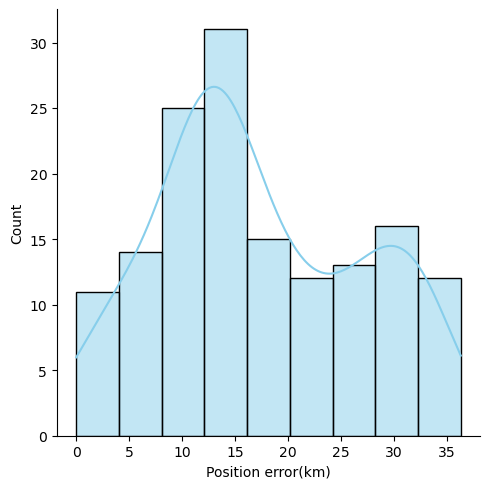

In [24]:
import seaborn as sns
ax = sns.displot(data = df["position_error(km)"], kde=True, color='skyblue')
ax.set(xlabel='Position error(km)')
plot_path_file = output_dir.joinpath("position_errors.png")
plt.savefig(str(plot_path_file), dpi=300)

Time with current
Benjamin simulation progress: : 191it [1:16:32, 24.04s/it]                                                                                                                                                                                  


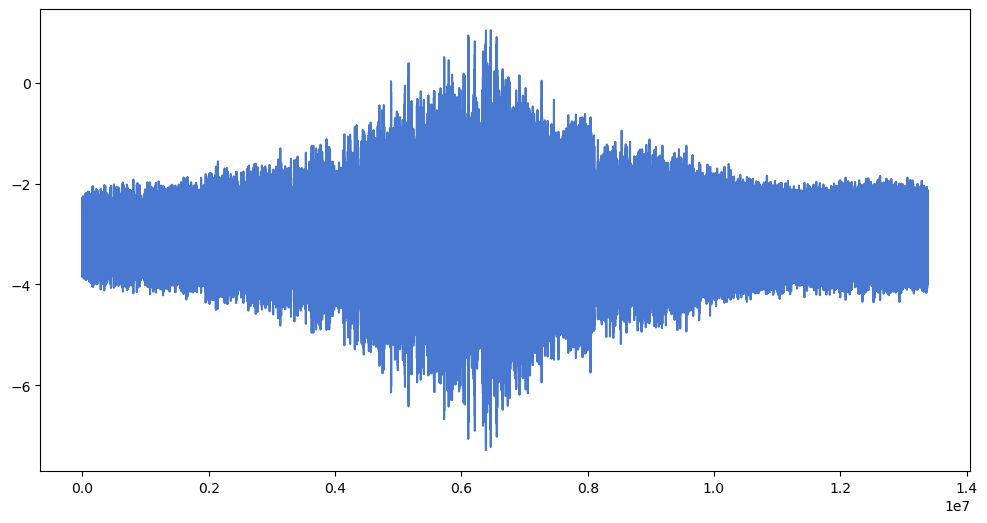

In [25]:
# Plot wave glider heave motion
plt.plot([position.z  for position  in simulated_path])